In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [1]:
class ExecutionAlgorithm:
    def __init__(self, file_path, train_end_date):
        """
        Inicializa la clase ExecutionAlgorithm con la ruta del archivo de datos y la fecha límite para dividir el conjunto de datos.
        
        Args:
            file_path (str): Ruta del archivo CSV con los datos de volumen y precio.
            train_end_date (str): Fecha límite para dividir los datos en entrenamiento y prueba.
        """
        self.file_path = file_path
        self.train_end_date = pd.Timestamp(train_end_date)
        self.data_df = None
        self.filtered_df = None
        self.resampled_df = None
        self.train_df = None
        self.test_df = None

    def load_data(self):
        """
        Carga los datos desde el archivo CSV y maneja excepciones si el archivo no existe o está vacío.
        """
        try:
            # Intentar cargar el archivo CSV
            self.data_df = pd.read_csv(self.file_path)
        except FileNotFoundError:
            # Manejar el caso en el que el archivo no se encuentra
            print(f"Error: El archivo {self.file_path} no fue encontrado.")
        except pd.errors.EmptyDataError:
            # Manejar el caso en el que el archivo está vacío
            print(f"Error: El archivo {self.file_path} está vacío.")
        except Exception as e:
            # Manejar cualquier otra excepción que ocurra durante la carga del archivo
            print(f"Error al leer el archivo: {e}")

    def preprocess_data(self):
        """
        Filtra los datos y realiza cálculos previos al análisis, como el cálculo del VWAP.
        - Elimina valores faltantes.
        - Filtra filas con volumen mayor a 0.
        - Calcula la columna 'vol_price' para el cálculo del VWAP.
        - Convierte las columnas de tiempo y fecha a sus formatos adecuados.
        - Agrupa los datos en intervalos de 5 minutos y calcula el VWAP.
        """
        if self.data_df is not None:
            # Manejar valores faltantes eliminando filas con datos faltantes
            self.data_df = self.data_df.dropna()
            # Filtrar filas con volumen mayor a 0
            self.filtered_df = self.data_df[self.data_df['volume'] > 0].copy()
            # Crear la columna vol_price para el VWAP
            self.filtered_df['vol_price'] = self.filtered_df['volume'] * self.filtered_df['price']
            # Convertir las columnas de tiempo y fecha a sus formatos adecuados
            self.filtered_df['time'] = pd.to_timedelta(self.filtered_df['time'])
            self.filtered_df['date'] = pd.to_datetime(self.filtered_df['date'])
            # Crear columna 'time_5min' para redondear a intervalos de 5 minutos
            self.filtered_df['time_5min'] = self.filtered_df['time'].dt.floor('5min')
            # Agrupar por 'date' y 'time_5min' para sumar el volumen y vol_price
            self.resampled_df = self.filtered_df.groupby(['date', 'time_5min']).agg({
                'volume': 'sum',
                'vol_price': 'sum'
            }).reset_index()
            # Calcular el VWAP
            self.resampled_df['vwap'] = self.resampled_df['vol_price'] / self.resampled_df['volume']
            # Eliminar filas con volumen igual a 0 después del resampleo
            self.resampled_df = self.resampled_df[self.resampled_df['volume'] > 0]
            # Eliminar la columna vol_price ya que ya no es necesaria
            self.resampled_df = self.resampled_df.drop(columns=['vol_price'])
        else:
            print("Error: No se han cargado datos para procesar.")

    def split_data(self):
        """
        Divide los datos en conjuntos de entrenamiento y prueba según la fecha límite especificada.
        """
        if self.resampled_df is not None:
            # Dividir los datos en entrenamiento y prueba utilizando la fecha límite
            self.train_df = self.resampled_df[self.resampled_df['date'] < self.train_end_date].copy()
            self.test_df = self.resampled_df[self.resampled_df['date'] >= self.train_end_date].copy()
            # Mostrar el número de filas en cada conjunto
            print(f"El dataset de entrenamiento tiene: {len(self.train_df)} filas y el de testeo tiene: {len(self.test_df)} filas")
        else:
            print("Error: No se han procesado datos para dividir.")

    def evaluate_model(self):
        """
        Evaluación básica del conjunto de datos dividido, mostrando las primeras filas del conjunto de entrenamiento y prueba.
        """
        if self.train_df is not None and self.test_df is not None:
            # Mostrar la primera fila del conjunto de entrenamiento
            print("Primera fila de train_df:")
            print(self.train_df.head(1))
            # Mostrar la primera fila del conjunto de prueba
            print("\nPrimera fila de test_df:")
            print(self.test_df.head(1))
        else:
            print("Error: No se han dividido los datos para evaluar.")


    def plot_training_volume_histogram(self):
        """
        Para cada día en el conjunto de entrenamiento, calcula el volumen total del mercado del día y grafica el histograma.
        """
        if self.train_df is not None:
            # Calcular el volumen total por día en el conjunto de entrenamiento
            daily_volume = self.train_df.groupby('date')['volume'].sum()
            # Graficar el histograma del volumen diario
            plt.figure(figsize=(10, 6))
            plt.hist(daily_volume, bins=30, edgecolor='k', alpha=0.7)
            plt.xlabel('Volumen Diario Total')
            plt.ylabel('Frecuencia')
            plt.title('Histograma del Volumen Diario Total en el Conjunto de Entrenamiento')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
        else:
            print("Error: No se han dividido los datos para graficar el volumen del entrenamiento.")

    def calculate_average_daily_volume(self):
        """
        Calcula el volumen diario promedio (ADV) como media y también como mediana sobre los volúmenes diarios.
        Compara la diferencia entre la media y la mediana, y discute las ventajas y desventajas de cada una.
        """
        if self.train_df is not None:
            # Calcular el volumen total por día en el conjunto de entrenamiento
            daily_volume = self.train_df.groupby('date')['volume'].sum()
            # Calcular la media y la mediana del volumen diario
            mean_adv = daily_volume.mean()
            median_adv = daily_volume.median()
            # Mostrar los resultados
            print(f"Volumen Diario Promedio (Media): {mean_adv:.2f}")
            print(f"Volumen Diario Promedio (Mediana): {median_adv:.2f}")
            print(f"Diferencia entre Media y Mediana: {abs(mean_adv - median_adv):.2f}")
            
            # Explicar ventajas y desventajas
            print("\nVentajas de usar la Media:")
            print("- Captura todos los valores, incluyendo valores extremos.")
            print("- Es útil cuando los datos tienen una distribución simétrica.")
            print("\nDesventajas de usar la Media:")
            print("- Es sensible a valores atípicos (outliers), lo que puede distorsionar el promedio.")
            
            print("\nVentajas de usar la Mediana:")
            print("- No se ve afectada por valores atípicos, lo que la hace más representativa en distribuciones asimétricas.")
            print("- Es más robusta cuando los datos tienen valores extremos.")
            
            print("\nDesventajas de usar la Mediana:")
            print("- No captura la magnitud de los valores extremos.")
            print("- Puede ser menos precisa si los valores están uniformemente distribuidos sin grandes outliers.")
        else:
            print("Error: No se han dividido los datos para calcular el volumen diario promedio.")

    def analyze_days_of_week(self):
        """
        Separa el conjunto de entrenamiento por días de la semana (lunes, martes, ... viernes) y realiza el análisis para cada día.
        Grafica el volumen promedio para cada día de la semana y compara los resultados con los resultados globales.
        """
        if self.train_df is not None:
            # Añadir una columna con el día de la semana (0=Lunes, 6=Domingo)
            self.train_df['day_of_week'] = self.train_df['date'].dt.weekday
            
            # Diccionario para mapear los números de los días de la semana a sus nombres
            weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
            
            # Inicializar el diccionario para almacenar los resultados
            weekday_vad_stats = {}
            
            # Calcular el volumen diario promedio (media y mediana) para cada día de la semana
            for weekday, weekday_name in weekday_map.items():
                # Filtrar el DataFrame para obtener solo los datos del día de la semana específico
                daily_volume_train = self.train_df[self.train_df['day_of_week'] == weekday].groupby('date')['volume'].sum()
                
                # Calcular la media y la mediana del volumen diario
                vad_mean = daily_volume_train.mean()
                vad_median = daily_volume_train.median()
                
                # Guardar los resultados en el diccionario
                weekday_vad_stats[weekday_name] = {'mean': vad_mean, 'median': vad_median}
            
            # Mostrar los resultados para cada día de la semana
            for day, stats in weekday_vad_stats.items():
                print(f"{day}:")
                print(f"  Volumen Medio Diario (VAD) - Media: {stats['mean']:.2f}")
                print(f"  Volumen Medio Diario (VAD) - Mediana: {stats['median']:.2f}\n")
            
            # Graficar la media del volumen diario por día de la semana
            plt.figure(figsize=(12, 6))
            plt.bar(weekday_vad_stats.keys(), [stats['mean'] for stats in weekday_vad_stats.values()], color='skyblue', edgecolor='k', alpha=0.7)
            plt.xlabel('Día de la Semana')
            plt.ylabel('Volumen Medio Diario (Media)')
            plt.title('Volumen Medio Diario por Día de la Semana en el Conjunto de Entrenamiento')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
        else:
            print("Error: No se han dividido los datos para analizar por día de la semana.")

    





El dataset de entrenamiento tiene: 75210 filas y el de testeo tiene: 31612 filas
Primera fila de train_df:
        date       time_5min  volume        vwap
0 2014-01-02 0 days 09:00:00   24732  131.060911

Primera fila de test_df:
            date       time_5min  volume        vwap
75210 2017-01-02 0 days 09:00:00   12139  156.039768


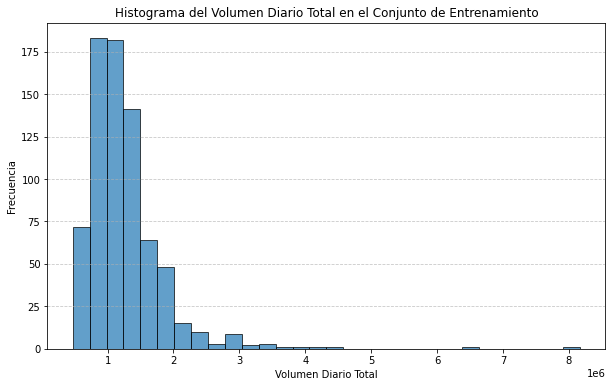

Volumen Diario Promedio (Media): 1261181.74
Volumen Diario Promedio (Mediana): 1136875.00
Diferencia entre Media y Mediana: 124306.74

Ventajas de usar la Media:
- Captura todos los valores, incluyendo valores extremos.
- Es útil cuando los datos tienen una distribución simétrica.

Desventajas de usar la Media:
- Es sensible a valores atípicos (outliers), lo que puede distorsionar el promedio.

Ventajas de usar la Mediana:
- No se ve afectada por valores atípicos, lo que la hace más representativa en distribuciones asimétricas.
- Es más robusta cuando los datos tienen valores extremos.

Desventajas de usar la Mediana:
- No captura la magnitud de los valores extremos.
- Puede ser menos precisa si los valores están uniformemente distribuidos sin grandes outliers.


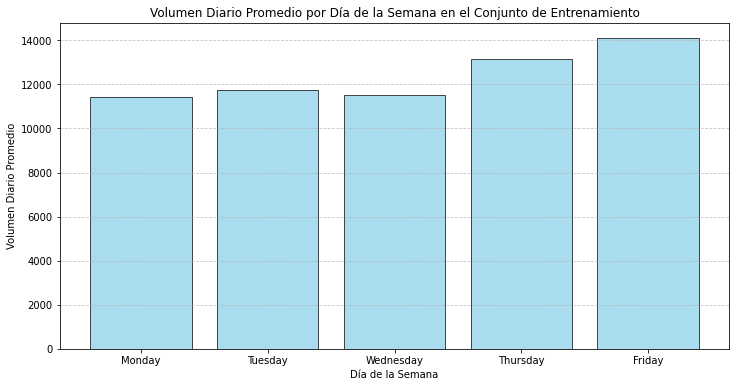

Volumen total por cada día de la semana:
day_of_week
Monday       163167799
Tuesday      184432497
Wednesday    178514700
Thursday     196846099
Friday       207791030
Name: volume, dtype: int64

Volumen promedio por cada día de la semana:
day_of_week
Monday       11426.316457
Tuesday      11742.805106
Wednesday    11523.024787
Thursday     13130.075974
Friday       14097.084803
Name: volume, dtype: float64

Análisis de patrones por días de la semana:
- Comparando los volúmenes entre los días de la semana, es posible identificar si hay días específicos con más actividad.
- Esto puede ser útil para detectar patrones de comportamiento del mercado, como mayor actividad los lunes o menor los viernes.


In [16]:
# Ejecución de la clase ExecutionAlgorithm
def main():
    """
    Punto de entrada principal para la ejecución del algoritmo de ejecución.
    Carga los datos, los preprocesa, los divide en entrenamiento y prueba, y realiza una evaluación básica.
    """
    # Definir la ruta del archivo y la fecha de corte para el conjunto de entrenamiento
    file_path = "volume_price_2014_18.csv"
    train_end_date = '2017-01-02'
    # Crear una instancia de la clase ExecutionAlgorithm
    algo = ExecutionAlgorithm(file_path, train_end_date)
    # Cargar los datos desde el archivo CSV
    algo.load_data()
    # Preprocesar los datos cargados
    algo.preprocess_data()
    # Dividir los datos en conjuntos de entrenamiento y prueba
    algo.split_data()
    # Evaluar la consistencia de los conjuntos de datos divididos
    algo.evaluate_model()
    # Graficar el histograma del volumen diario total en el conjunto de entrenamiento
    algo.plot_training_volume_histogram()
    # Calcular el volumen diario promedio (ADV) y discutir la diferencia entre media y mediana
    algo.calculate_average_daily_volume()
    # Analizar los volúmenes por días de la semana
    algo.analyze_days_of_week()

# Ejecutar la función main si el script se ejecuta directamente
if __name__ == "__main__":
    main()